# MULTI-CLASS STELLAR CLASSIFICATION USING SCIKIT-LEARN

In [ ]:
# Import Libraries

import warnings
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, recall_score,f1_score, roc_auc_score, log_loss, classification_report,ConfusionMatrixDisplay)
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# stellar-classification-dataset-sdss17 

DATASET_CSV = "star_classification.csv"

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Function: Load Data
def load_data(file):
    """Load the dataset into a pandas DataFrame."""
    try:
        df = pd.read_csv(file)
        print("Dataset loaded successfully.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Function: Explore Data

def explore_data(df):

    red_shift_number = (df['redshift']>0).sum()
    blue_shift_number = (df['redshift']<0).sum()

    """Display dataset overview and statistics."""
    print("Dataset Shape:", df.shape)
    print(f'The number of objects going away from us is : {red_shift_number} & the number of objects coming closer to us is : {blue_shift_number}')
    print(f"The percentage of different celestial bodies:\n{(df['class'].value_counts() / len(df) ) * 100 } ") 


def clean_data(df):
    
    # Removing unnecessary column 
    df = df.drop("rerun_ID",axis=1) 

    # When the SSPP is unable to calculate a particular stellar parameter for a target, due to things such as a substandard S/N, the placeholder in the data table is -9999. 
    # We remove that certain row from our dataframe.

    row_number = df[(df[['r', 'g', 'i', 'u', 'z']] == -9999).any(axis=1)]
    index_number = df.index.get_loc(row_number.index[0])
    df = df.drop(index_number)
    return df

In [3]:
# Function: Train-Test Split

def split_data(features, target, test_size=0.2, random_state=42):
    """Split data into train and test sets."""
    return train_test_split(features, target, test_size=test_size, random_state=random_state)

In [4]:
# Function: Train Model

def train_model(X_train, y_train, model_type):
    """Train a specified model (SVM, XGBoost, or KNN)."""
    if model_type == 'Random Forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)

    elif model_type == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=0)

    elif model_type == 'SVM':
        model = svm.SVC(kernel='linear', C = 1)

    elif model_type == 'XGBoost':
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    elif model_type == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5)

    else:
        raise ValueError("Invalid model type. Choose 'Random Forest' , 'Decision Tree' , 'SVM', 'XGBoost', or 'KNN'.")

    model.fit(X_train, y_train)
    print(f"{model_type} model trained successfully.")
    return model

# Function: Evaluate Model

def evaluate_model(model, X_test, y_test,model_type):
    """Evaluate model performance."""
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

Dataset loaded successfully.
Dataset Shape: (100000, 18)
The number of objects going away from us is : 85864 & the number of objects coming closer to us is : 13724
The percentage of different celestial bodies:
GALAXY    59.445
STAR      21.594
QSO       18.961
Name: class, dtype: float64 

Training SVM Model...
SVM model trained successfully.
Accuracy: 0.81155

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.75      0.83     11860
           1       0.96      1.00      0.98      4343
           2       0.52      0.79      0.63      3797

    accuracy                           0.81     20000
   macro avg       0.80      0.85      0.81     20000
weighted avg       0.85      0.81      0.82     20000



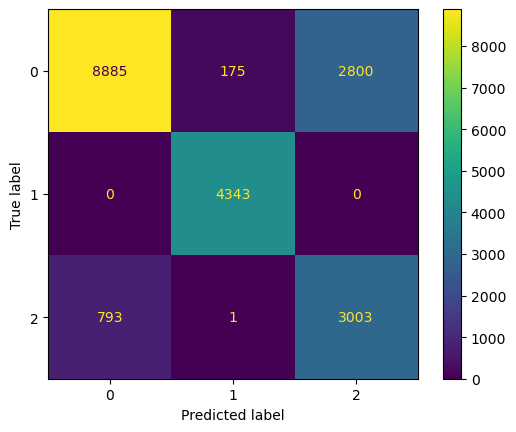

In [6]:
# Main Execution

if __name__ == "__main__":
    
    # Step 1: Load Data
    data = load_data(DATASET_CSV)
    
    if data is not None:
        # Step 2: Explore Data
        explore_data(data)
        
        # Step 3: Clean the data
        clean_data(data)

        # Step 4: Feature and Target Selection

        numeric_classification = {'GALAXY':0, 'STAR':1, 'QSO':2}
        data['class'] = data['class'].map(numeric_classification)
        features = data.drop('class',axis = 1 )  # Modify features based on dataset 
        target = data['class']  # Modify based on target column
        
        # Step 5: Train-Test Split
        X_train, X_test, y_train, y_test = split_data(features, target)
        
        # Step 6: Train and Evaluate your model of your choice

        model_list = ['Random Forest' , 'Decision Tree' , 'SVM', 'XGBoost', 'KNN']
        model_name = model_list[2]

        print(f"\nTraining {model_name} Model...")

        if model_name == 'KNN' or model_name == 'SVM':

            # SCALING KNN Improves it's accuracy from 69% to 91%. DO TRY IT :D
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.fit_transform(X_test)
            user_model = train_model(X_train, y_train, model_type= model_name)
            evaluate_model(user_model, X_test, y_test,model_type = model_name )

        else:

            user_model = train_model(X_train, y_train, model_type= model_name)
            evaluate_model(user_model, X_test, y_test,model_type = model_name )